Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 60s 158ms/step - accuracy: 0.6243 - loss: 0.6400 - val_accuracy: 0.8343 - val_loss: 0.3773
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.8412 - loss: 0.3713 - val_accuracy: 0.8678 - val_loss: 0.3135
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.8636 - loss: 0.3223 - val_accuracy: 0.8851 - val_loss: 0.2750
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.8823 - loss: 0.2770 - val_accuracy: 0.8843 - val_loss: 0.2729
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.8932 - loss: 0.2615 - val_accuracy: 0.8913 - val_loss: 0.2611
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.8998 - loss: 0.2413 - val_accuracy: 0.8976 - val_loss: 0.2424
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.9152 - loss: 0.2057 - val_accuracy: 0.9017 - val_loss: 0.2438
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.9149 - loss: 0

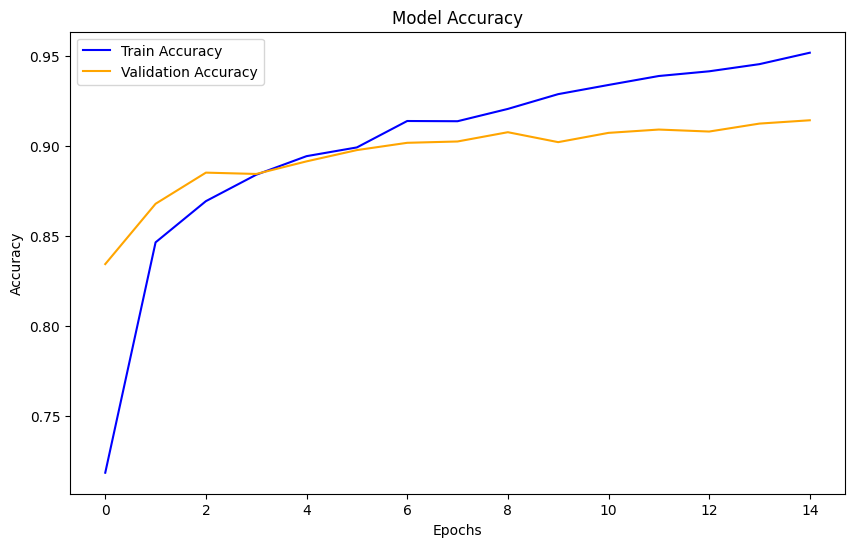

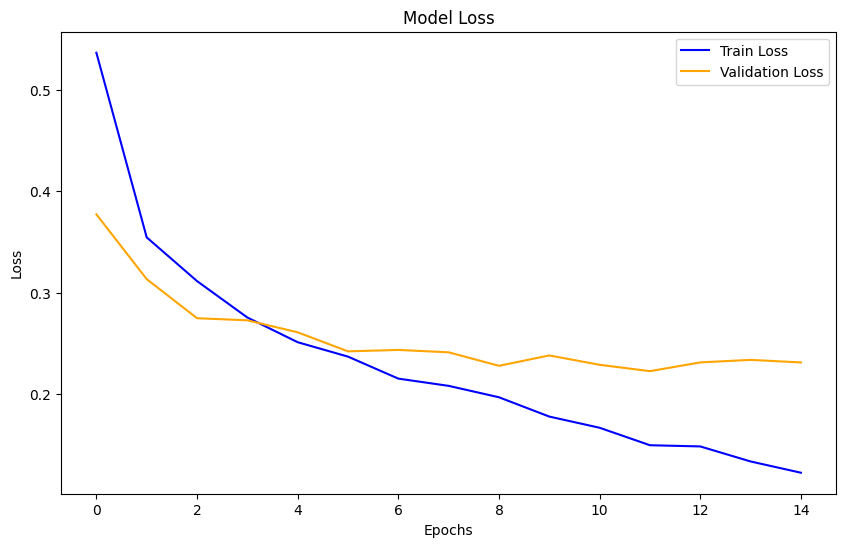

In [11]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Set file paths
image_dir = '/content/drive/MyDrive/Stats201_FinalProject/Final_Project/images'
train_path = '/content/drive/MyDrive/Stats201_FinalProject/Final_Project/train_filtered.csv'
test_path = '/content/drive/MyDrive/Stats201_FinalProject/Final_Project/test_filtered.csv'
val_path = '/content/drive/MyDrive/Stats201_FinalProject/Final_Project/val_filtered.csv'

# Load the CSV files into pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(val_path)

# Prepare image paths and labels
train_image_paths = [os.path.join(image_dir, f"{img_id}.jpg") for img_id in train_df['ID']]
test_image_paths = [os.path.join(image_dir, f"{img_id}.jpg") for img_id in test_df['ID']]
val_image_paths = [os.path.join(image_dir, f"{img_id}.jpg") for img_id in val_df['ID']]

train_labels = train_df['label'].values
test_labels = test_df['label'].values
val_labels = val_df['label'].values

# Data Augmentation for better generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

# Load the pre-trained ResNet50 model without the top layer for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to reduce spatial dimensions
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Dense layer for non-linearity
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[:140]:  # Freeze all layers except the last few
    layer.trainable = False
for layer in base_model.layers[140:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img

# Create a tf.data.Dataset for the images and labels
def create_dataset(image_paths, labels, batch_size=32):
    # Create a tf.data.Dataset from the image paths and labels
    image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # Map the image loading and preprocessing function to the dataset
    dataset = tf.data.Dataset.zip((image_paths_ds, labels_ds))
    dataset = dataset.map(lambda img_path, label: (load_and_preprocess_image(img_path), label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Apply data augmentation to the images
    dataset = dataset.map(lambda img, label: (data_augmentation(img), label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch to optimize the loading pipeline
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare datasets for training, validation, and testing
train_dataset = create_dataset(train_image_paths, train_labels)
val_dataset = create_dataset(val_image_paths, val_labels)
test_dataset = create_dataset(test_image_paths, test_labels)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and capture the history
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stopping])

# Evaluate the model on the test set
test_preds = model.predict(test_dataset)
test_preds = (test_preds > 0.5).astype(int)  # Convert probabilities to class labels


# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [10]:
# Predict on the test set and evaluate the performance
y_test_pred = model.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.9414814814814815
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1328
           1       0.96      0.92      0.94      1372

    accuracy                           0.94      2700
   macro avg       0.94      0.94      0.94      2700
weighted avg       0.94      0.94      0.94      2700

